# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
The is the problem introduction:

Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1)$ and $a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. Problem formulation

### Discription:

![Project_1](img/Project_1.png)

This is a 2-D problem. At the beginning, the rocket has a initial location (x, y) and initial velocity (x_dot, y_dot). The nozzle of the rocket can rotate to change the direction of thrust. The angle between the thrust direction and y-axis is alpha. The ratio of the thrust can also change.

### Assumptions: 
The rocket is considered as a mass dot. Therefore, the rotation movement of the rocket is not considered.

### Variables:
s: state

x: x coordinate

x_dot: velocity in x direction

y: y coordinate 

y_dot: velocity in y direction

A: the ratio of the thrust, range from 0 to 1.  

alpha: the angle between the thrust direction and y-axis. 


### Objective function:

$$
\begin{aligned}
\min_{\theta} \quad & ||s(T)||^2 
\end{aligned}
$$

### Constraints:

$$
\begin{aligned}
\quad & x(t+1) = x(t) + v_x(t) \Delta t, \\
\quad & y(t+1) = x(t) + v_y(t) \Delta t, \\
\quad & v_x(t+1) = v_x(t) + a_x(t) \Delta t, \\
\quad & v_y(t+1) = v_y(t) + a_y(t) \Delta t, \\
\quad & a_x(t), a_y(t) = f_{\theta}(s(t)), ~\forall t=1,...,T-1 
\end{aligned}
$$

---

## 3. Code

In [38]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = 10.0  # m/s2, gravity constant
BOOST_ACCEL = 20.0  # m/s2, thrust constant

# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity       
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        # Thrust
        alpha = action[1]*math.pi-math.pi/2.0
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., math.cos(alpha), 0., math.sin(alpha)]) * action[0]

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [10., 0., 10., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        y1 = data[:, 0]
        y2 = data[:, 1]
        x1 = data[:, 2]
        x2 = data[:, 3]
        plt.plot(y1, y2)
        plt.plot(x1, x2)
        plt.show()

[1] loss: 28593.932


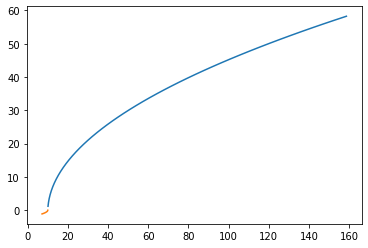

[2] loss: 27288.938


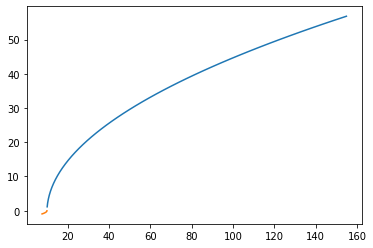

[3] loss: 26228.971


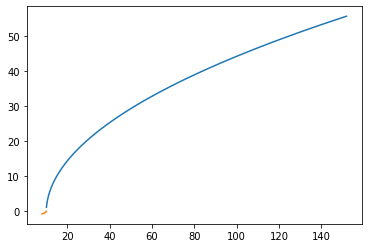

[4] loss: 25366.885


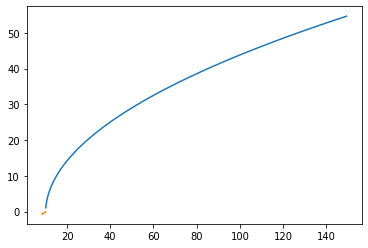

[5] loss: 24664.352


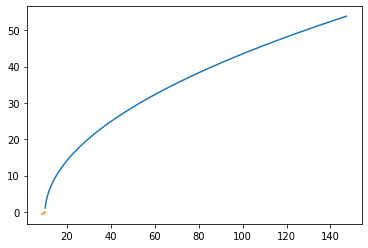

[6] loss: 24090.955


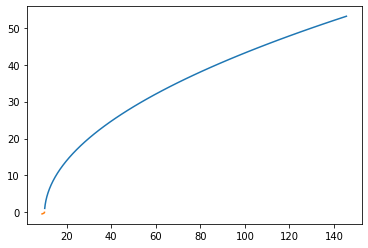

[7] loss: 23622.412


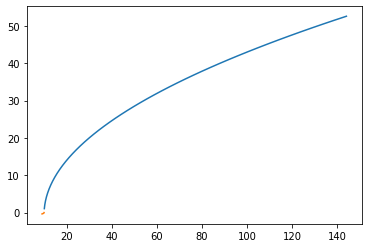

[8] loss: 23239.244


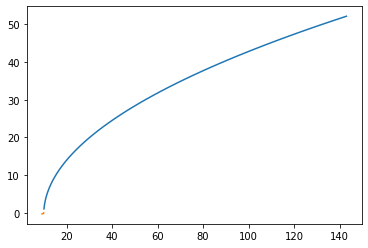

[9] loss: 22925.715


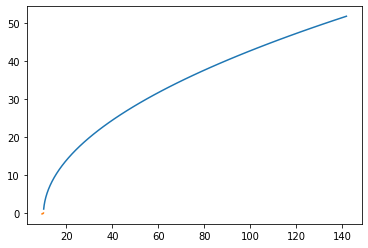

[10] loss: 22669.090


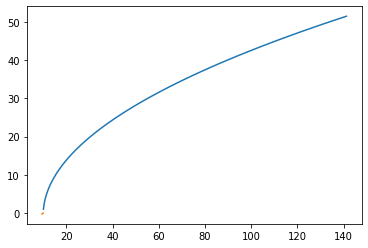

[11] loss: 22458.916


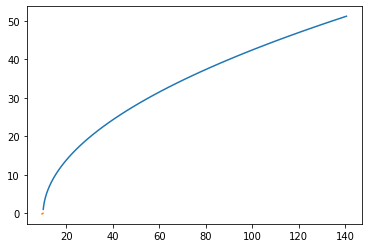

[12] loss: 22286.828


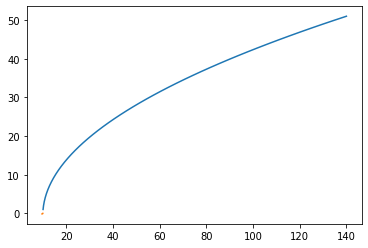

[13] loss: 22145.844


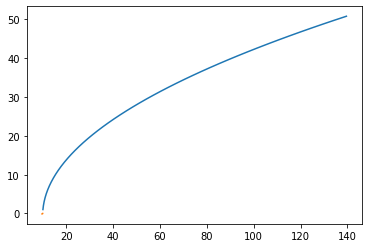

[14] loss: 22030.346


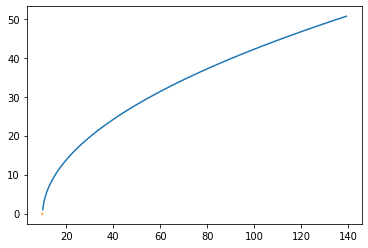

[15] loss: 21935.697


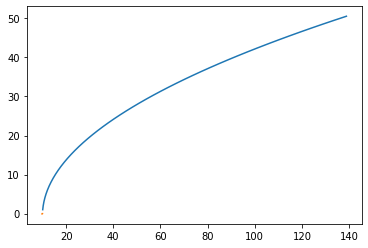

[16] loss: 21858.172


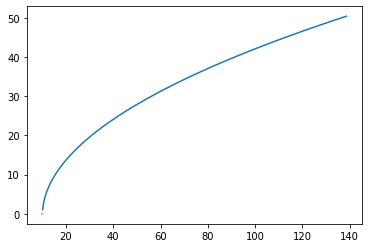

[17] loss: 21794.650


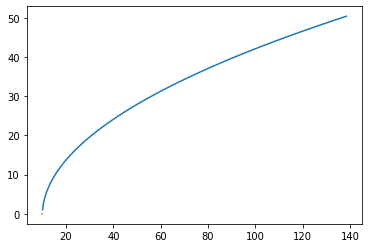

[18] loss: 21742.590


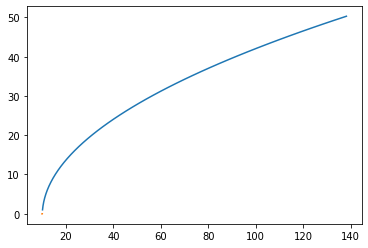

[19] loss: 21699.930


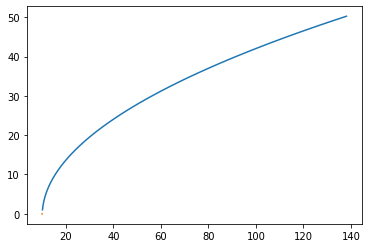

[20] loss: 21664.963


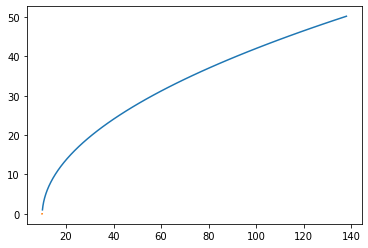

[21] loss: 21636.312


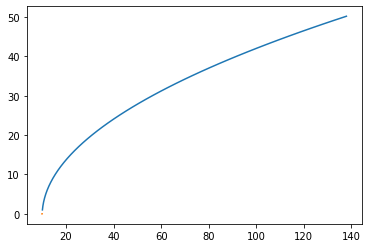

[22] loss: 21612.838


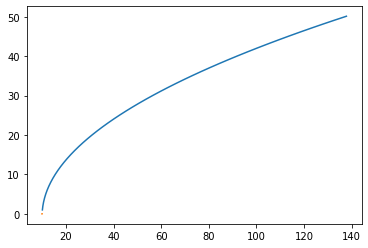

[23] loss: 21593.592


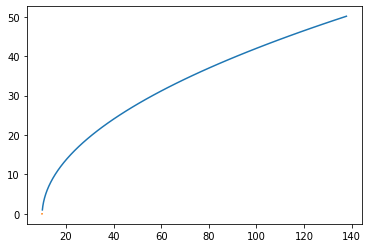

[24] loss: 21577.836


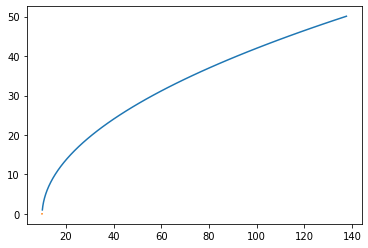

[25] loss: 21564.926


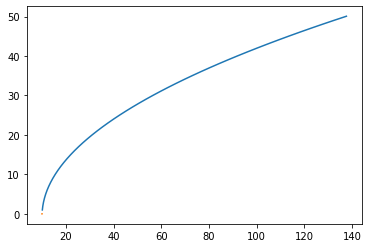

[26] loss: 21554.330


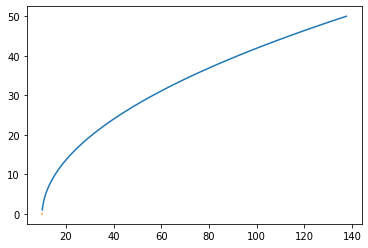

[27] loss: 21545.643


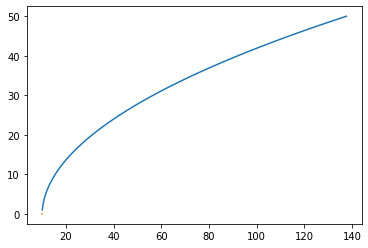

[28] loss: 21538.545


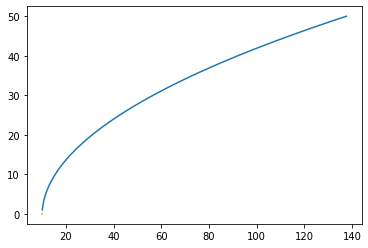

[29] loss: 21532.707


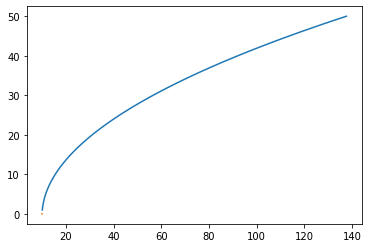

[30] loss: 21527.943


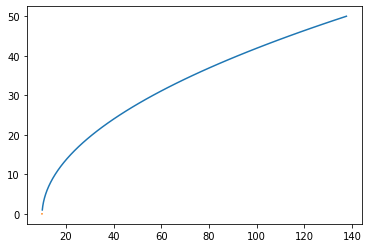

KeyboardInterrupt: 

In [39]:
# Now it's time to run the code!

T = 50  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(100)  # solve the optimization problem

## 4. Analysis